# This notebook shows the codes for the "ML and critical gene identifier" module

In [1]:
%pip install -q -r requirements3.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
sys.path.append("..")
sys.path.append("../src")
from src.eda.process_phenotype import *
from src.eda.eda_functions import gene_phenotype_corr, plot_corr_kde
from src.models.feature_extraction import *
from src.models.ML_functions import *

# Load embedding

In [3]:
%%time
emb_df = pd.read_csv('../data/notebooks/Module 5 outputs/embedding.csv', index_col = 0)
emb_name = 'epoch=100_alpha=0.1'

Wall time: 386 ms


In [4]:
%%time
deseq = pd.read_excel('../data/deseq.alc.vs.control.age.rin.batch.gender.PMI.corrected.w.prot.coding.gene.name.xlsx')

Wall time: 1.27 s


In [5]:
%%time
# process embedding to be ready for ML
processed_emb_df = process_emb_for_ML(emb_df, deseq)

Wall time: 27.2 ms


# Run ML on the embedding

lr average: 65 ;  rf average: 77 ;  xgb_average: 79
Removing existing folder: output
Created folder output


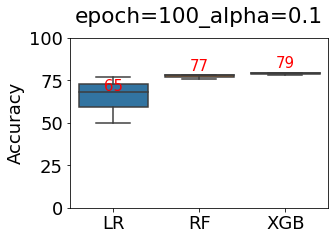

In [6]:
model_weights = run_ml(processed_emb_df, emb_name = emb_name, print_accuracy = True)

# Getting the feature importances and the dimensions that make up 50% of feature importances

In [7]:
top_dim = plot_feature_importances(model_weights, top_n_coef = 0.5, print_num_dim = False, plot_heatmap = False, return_top_dim = True)

# Check the performance using only the top 50% important features 

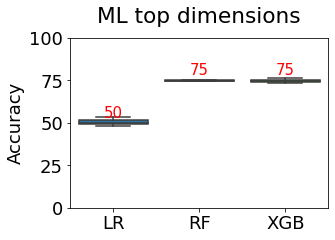

In [8]:
plot_ml_w_top_dim(processed_emb_df, top_dim)

## Determine jaccard similarity for the overlap of the important dimensions between 3 repeats of each ML model

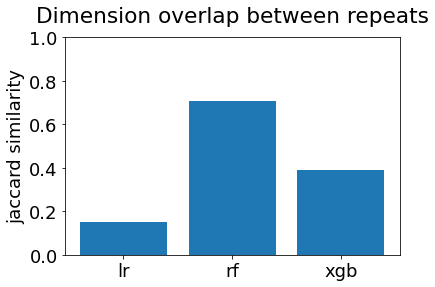

In [9]:
jaccard_average(top_dim, 'Dimension overlap between repeats')

# Identify critical genes from the parameters used (3 models, 3 repeats)

In [10]:
output_path = '../data/notebooks/Module 6 output/critical_gene_df.csv'

## Note that this would overwrite the critical_gene_df.csv in the output folder

In [11]:
%%time
critical_gene_df = get_critical_gene_df(processed_emb_df, top_dim, deseq = deseq, output_path = output_path, aimed_number = 500, within_n = 30, models = ['RF', 'XGB'])

CPU times: user 1min 17s, sys: 24.6 s, total: 1min 42s
Wall time: 1min 26s


In [12]:
critical_gene_df.head()

,gene,RF_repeat1,RF_repeat2,RF_repeat3,XGB_repeat1,XGB_repeat2,XGB_repeat3,near_impact_cnt
0,ENSG00000197857,2.0,2.0,3.0,3.0,3.0,3.0,16.0
1,ENSG00000188133,3.0,3.0,3.0,2.0,2.0,2.0,15.0
2,ENSG00000157833,2.0,2.0,2.0,2.0,2.0,2.0,12.0
3,ENSG00000139144,3.0,2.0,1.0,3.0,0.0,3.0,12.0
4,ENSG00000198342,2.0,2.0,2.0,2.0,2.0,2.0,12.0


# Check critical gene overlap between the three models

In [13]:
intersect_genes = jaccard_critical_genes(critical_gene_df, 'Critical gene overlap between models')

critical gene overlap between models ['RF vs XGB'] is 0.538


# Plot top 10 critical genes

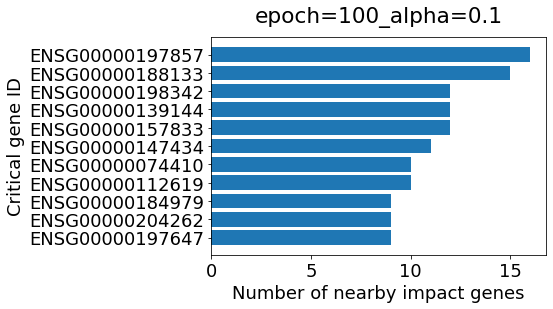

In [14]:
critical_gene_set2 = plot_nearby_impact_num(critical_gene_df, emb_name)

# Plot correlation between the critical genes and alcohol traits

In [15]:
expression_meta = pd.read_csv('../data/notebooks/Module 1-4 outputs/expression_meta_Apr6.csv', low_memory = False)

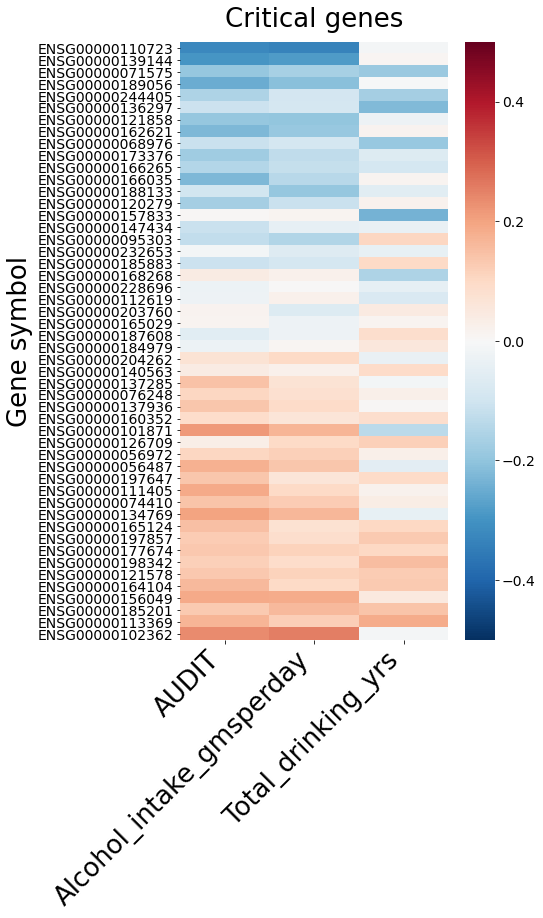

In [16]:
cg_corr = gene_phenotype_corr(critical_gene_df.gene[:50], expression_meta, 'Critical genes')

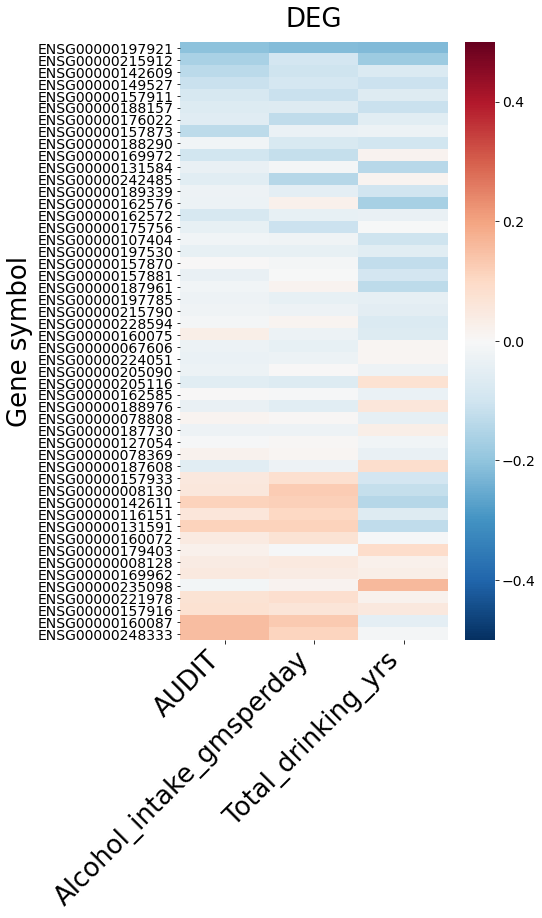

In [17]:
deg_corr = gene_phenotype_corr(deseq.id[:50], expression_meta, 'DEG')

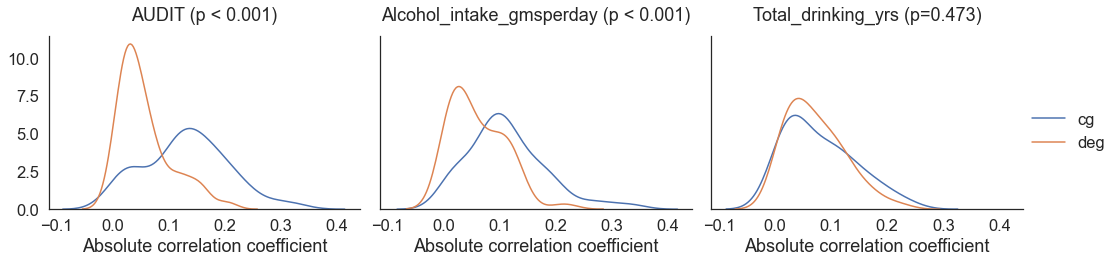

In [18]:
plot_corr_kde([cg_corr, deg_corr], ['cg','deg'], 'CG vs DEG')